In [1]:
import jax
from jax import numpy as jnp
import matplotlib.pyplot as plt
import ces
import balance

In [2]:
class balance_module():
    def __init__(self, n, m, rho_min = 0.1, rho_max = 10, seed = 0):
        self.n = n
        self.m = m
        self.key = jax.random.PRNGKey(seed)
        
        self.rho_min = rho_min
        self.rho_max = rho_max
        self.rho = jax.random.uniform(self.key, (n,), minval= rho_min, maxval = rho_max)
        self.Z = jnp.zeros((n+m, n))
        self.Z = self.Z.at[:n,:].set(jnp.ones((n,n))/(n+1))
        self.Z = self.Z.at[n:,:].set(jnp.ones((m,n)))
        
    def forward(self, Z, rho, s, h, Z0): 
        W = ces.W(Z, rho)
        p = ces.balance_prices(W, rho, s, h)
        J = ces.J(p, W, rho)
        Z_pred = balance.J_to_Z(J, Z0) 
        return Z_pred
    
    def loss(self, params, x, y): #по-хорошему loss нужно сделать снаружи, а тут сделать только train 
        Z, rho = params
        s, h, Z0 = x
        Z_target = y
        Z_pred = self.forward(Z, rho, s, h, Z0)
        loss = jnp.trace(jnp.transpose(Z_pred - Z_target) @ (Z_pred - Z_target))
        return loss

In [3]:
n, m = 33, 3
tables = balance.read_NIOT('NIOTS/RUS_NIOT_nov16.xlsx')
Z_target = tables[14][:,:n]                           
Z0 = jnp.sum(tables[14][:,n:], axis = 1)[:n]
s = jnp.ones((m,))
h = jnp.zeros((n,))
model = balance_module(n, m)
model.Z = tables[13][:,:n]
rho_bad = jnp.array([6.2238083, 0.1, 5.8205304, 7.1875806, 9.16447, 2.919602, 3.565998,
           3.560337, 1.2712448, 3.534269, 8.417102, 1.698983, 1.9197848, 8.21868,
           3.623436, 7.301276, 4.6853094, 3.9526048, 7.5603304, 5.5858884, 6.32079,
           4.484683, 8.182239, 4.472176, 3.2741904, 1.5513074, 4.2444315, 8.1515465,
           6.1587143, 0.6000987, 3.2279983, 5.2498374, 2.1840897])
#model.rho = rho_bad

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
model.loss((model.Z, model.rho), (s, h, Z0), (Z_target))

Array(4.0365328e+08, dtype=float32)

In [42]:
DATA = [((s, h, Z0), (Z_target))]
gamma = 100 #длина шага
cum_Z, cum_rho = 0, 0
eps_rho = 1
N = 4
eps_Z = 2 ** N
while eps_Z >= 2 ** N:
    grad_Z = jnp.zeros((n+m, n))
    grad_rho = jnp.zeros((n,))
    for x, y in DATA:
        last_loss = model.loss((model.Z, model.rho), x, y)
        grad = jax.jacfwd(model.loss)((model.Z, model.rho), x, y)
        grad_Z += grad[0]
        grad_rho += grad[1]
    #eps_rho = jnp.dot(grad_rho, grad_rho)
    eps_Z = jnp.trace(jnp.transpose(grad_Z) @ grad_Z)
    print(eps_Z, last_loss)
    print('_______')
    #cum_rho += eps_rho
    cum_Z += eps_Z
    Z = model.Z - gamma/jnp.sqrt(cum_Z) * grad_Z
    #rho = model.rho - gamma/jnp.sqrt(cum_rho) * grad_rho
    #rho = jnp.minimum(jnp.maximum(rho, 0.5),5)
    model.Z= model.Z.at[:,:].set(jnp.maximum(Z, 0.1))
    #model.rho= model.rho.at[:].set(rho)

29.257101 9.172903
_______
217057.58 9096.401
_______
26380792.0 220683.9
_______
2354230.0 19607.469
_______
351139.44 5175.346
_______
65166.53 3061.297
_______
17647.098 2585.9165
_______
9172.781 2384.631
_______
7383.008 2238.4897
_______
6737.6924 2107.31
_______
6306.9014 1985.3093
_______
5934.131 1870.8707
_______
5591.41 1763.3784
_______
5268.323 1661.6487
_______
4963.314 1565.6475
_______
4678.7217 1475.9792
_______
4408.965 1390.9683
_______
4155.692 1311.0369
_______
3916.3062 1235.6326
_______
3690.3403 1164.4204
_______
3477.2375 1097.1439
_______
3278.1968 1034.267
_______
3089.2964 974.8508
_______
2911.3813 918.7094
_______
2744.0327 865.9004
_______
2585.4595 815.9512
_______
2436.9512 768.99866
_______
2296.9717 724.8214
_______
2164.6172 683.14624
_______
2040.6958 643.9953
_______
1922.5704 606.71405
_______
1812.3152 572.0047
_______
1707.8611 539.1041
_______
1609.2185 508.03824
_______
1517.2189 478.98187
_______
1429.3792 451.2837
_______
1347.4885 425.4283


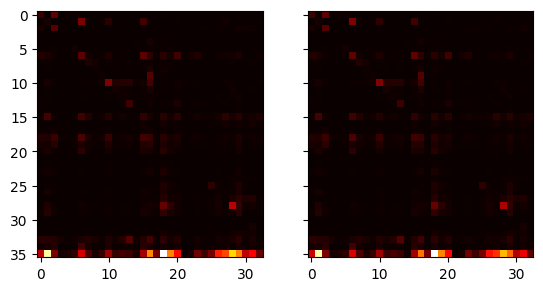

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(Z_target, cmap='hot', interpolation='nearest')
ax2.imshow(model.Z, cmap='hot', interpolation='nearest')

При фиксированных $\rho$ оно выучивает базовый год, но долго, муторно и с рестартами. Про рестарты особенно интересно - функция ну явно не сильно выпукла, но заметно помогает. 